In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/colab/ImageStyleTransfer")

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision

from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 均已测试

print(device, torch.__version__)

cuda 1.7.0+cu101


In [4]:
torch.cuda.is_available()

True

In [5]:
!nvidia-smi

Thu Dec 17 06:32:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

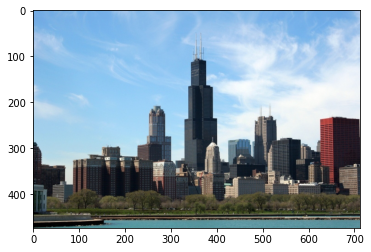

In [6]:
# content_img = Image.open('content.png').convert('RGB')
content_img = Image.open('content/test.jpg').convert('RGB')

plt.imshow(content_img);

<PIL.Image.Image image mode=RGB size=938x640 at 0x7F52D23345F8>


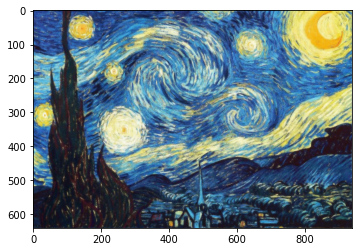

In [7]:
style_img = Image.open('style/denoised_starry.jpg').convert('RGB')

print(style_img)
plt.imshow(style_img);

In [8]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(PIL_img, image_shape):
    process = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])

    return process(PIL_img).unsqueeze(dim = 0) # (batch_size, 3, H, W)

def postprocess(img_tensor):
    inv_normalize = torchvision.transforms.Normalize(
        mean= -rgb_mean / rgb_std,
        std= 1/rgb_std)
    to_PIL_image = torchvision.transforms.ToPILImage()
    return to_PIL_image(inv_normalize(img_tensor[0].cpu()).clamp(0, 1))

In [12]:
pretrained_net = torchvision.models.vgg19(pretrained=True)
# pretrained_net.load_state_dict(torch.load('/root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth'))

In [13]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
weight_style = [0.5, 1, 1.5, 3, 4]

In [14]:
net_list = []
for i in range(max(content_layers + style_layers) + 1):
    net_list.append(pretrained_net.features[i])
net = torch.nn.Sequential(*net_list)


In [15]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    j = 0
    for i in range(len(net)):
        X = net[i](X)       
        if i in style_layers:
            styles.append(X*weight_style[j])
            # styles.append(X)

            j += 1
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [16]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [17]:
def content_loss(Y_hat, Y):
    return F.mse_loss(Y_hat, Y)

In [18]:
def gram(X):
    num_channels, n = X.shape[1], X.shape[2] * X.shape[3]
    X = X.view(num_channels, n)
    return torch.matmul(X, X.t()) / (num_channels * n)

In [19]:
def style_loss(Y_hat, gram_Y):
    return F.mse_loss(gram(Y_hat), gram_Y)

In [20]:
def tv_loss(Y_hat):
    return 0.5 * (F.l1_loss(Y_hat[:, :, 1:, :], Y_hat[:, :, :-1, :]) + 
                  F.l1_loss(Y_hat[:, :, :, 1:], Y_hat[:, :, :, :-1]))

In [21]:
# content_weight, style_weight, tv_weight = 1, 1e3, 10
content_weight, style_weight, tv_weight = 1.0, 1e5, 100.0

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l) + sum(contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

In [22]:
class GeneratedImage(torch.nn.Module):
    def __init__(self, img_shape):
        super(GeneratedImage, self).__init__()
        self.weight = torch.nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [23]:
def get_inits(X, device, lr, styles_Y):
    gen_img = GeneratedImage(X.shape).to(device)
    gen_img.weight.data = X.data
    optimizer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, optimizer

In [24]:
def train(X, contents_Y, styles_Y, device, lr, max_epochs, lr_decay_epoch):
    print("training on ", device)
    X, styles_Y_gram, optimizer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, gamma=0.0001)
    for i in range(max_epochs):
        start = time.time()
        
        contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        
        optimizer.zero_grad()
        l.backward(retain_graph = True)
        optimizer.step()
        scheduler.step()
        
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, sum(contents_l).item(), sum(styles_l).item(), tv_l.item(),
                     time.time() - start))
    return X.detach()

training on  cuda
epoch  50, content loss 4.99, style loss 10556.28, TV loss 21.67, 0.07 sec
epoch 100, content loss 5.04, style loss 6193.50, TV loss 22.46, 0.07 sec
epoch 150, content loss 5.07, style loss 4639.46, TV loss 22.94, 0.07 sec
epoch 200, content loss 5.10, style loss 3813.15, TV loss 23.30, 0.07 sec
epoch 250, content loss 5.11, style loss 3304.08, TV loss 23.58, 0.07 sec
epoch 300, content loss 5.12, style loss 2938.78, TV loss 23.83, 0.07 sec
epoch 350, content loss 5.13, style loss 2660.30, TV loss 24.04, 0.07 sec
epoch 400, content loss 5.14, style loss 2437.71, TV loss 24.22, 0.07 sec
epoch 450, content loss 5.15, style loss 2258.28, TV loss 24.38, 0.07 sec
epoch 500, content loss 5.15, style loss 2111.03, TV loss 24.52, 0.07 sec
epoch 550, content loss 5.17, style loss 1984.17, TV loss 24.66, 0.07 sec
epoch 600, content loss 5.17, style loss 1876.61, TV loss 24.79, 0.07 sec
epoch 650, content loss 5.18, style loss 1787.09, TV loss 24.91, 0.07 sec
epoch 700, content 

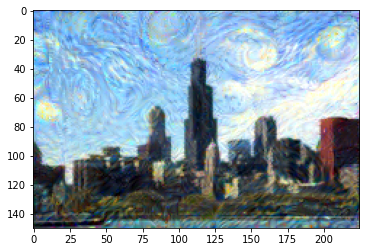

In [25]:
image_shape =  (150, 225)
# image_shape = (600, 800)
# image_shape =  (256, 256)

net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
style_X, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.02, 3000, 5000)

out = postprocess(output)
plt.imshow(out)
# out.save('big2.jpg')

In [ ]:
# image_shape = (300, 450)
# net = net.to(device)
# _, content_Y = get_contents(image_shape, device)
# _, style_Y = get_styles(image_shape, device)
# X = preprocess(postprocess(output), image_shape).to(device)
# big_output = train(X, content_Y, style_Y, device, 0.01, 500, 200)
# bigout = postprocess(big_output)
# plt.imshow(bigout);
# bigout.save('bigout.jpg')

training on  cuda
epoch  50, content loss 1.76, style loss 640.93, TV loss 19.30, 0.66 sec
epoch 100, content loss 1.77, style loss 233.82, TV loss 18.10, 0.66 sec
epoch 150, content loss 1.77, style loss 131.07, TV loss 17.42, 0.66 sec
epoch 200, content loss 1.77, style loss 91.06, TV loss 17.03, 0.66 sec
epoch 250, content loss 1.77, style loss 79.40, TV loss 16.84, 0.66 sec
epoch 300, content loss 1.77, style loss 64.92, TV loss 16.67, 0.66 sec
epoch 350, content loss 1.77, style loss 54.57, TV loss 16.57, 0.66 sec
epoch 400, content loss 1.77, style loss 46.94, TV loss 16.51, 0.66 sec
epoch 450, content loss 1.76, style loss 130.65, TV loss 16.46, 0.66 sec
epoch 500, content loss 1.77, style loss 39.74, TV loss 16.43, 0.66 sec
epoch 550, content loss 1.77, style loss 39.07, TV loss 16.43, 0.66 sec
epoch 600, content loss 1.77, style loss 32.92, TV loss 16.34, 0.66 sec
epoch 650, content loss 1.77, style loss 36.46, TV loss 16.37, 0.66 sec
epoch 700, content loss 1.77, style loss 2

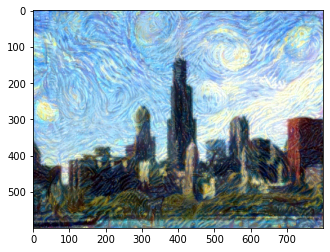

In [26]:
image_shape = (600, 800)
net = net.to(device)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output), image_shape).to(device)
big_output = train(X, content_Y, style_Y, device, 0.04, 2000, 5000)
out6x8 = postprocess(big_output)
plt.imshow(out6x8)
out6x8.save('out6x8.jpg')
